In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore"
                         )
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def training_plot(history, epoch, plot_name):
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']
    
    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title(f'Training & Testing Loss: {plot_name}')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    
    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title(f'Training & Testing Accuracy: {plot_name}')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    
    plt.savefig(f'Training & Testing Accuracy: {plot_name}.png', dpi=300)
    plt.show()

In [3]:
# Data = "/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO"

In [4]:
Features = pd.read_csv("/kaggle/input/subesco-features/features.csv")

In [5]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-296.230011,38.119564,-13.094496,9.386072,-5.185539,-1.639019,-24.183292,-0.357210,-23.233494,0.508763,...,-1.771268,-0.732451,-2.919358,-1.677924,-3.435302,-9.161626,2.760259,-2.452390,4.650526,FEAR
1,-294.331106,38.511047,-13.068908,9.291030,-4.891412,-1.578612,-24.080665,-0.513611,-23.064030,0.513141,...,-1.921915,-0.734482,-3.032744,-1.649717,-3.451801,-9.120968,2.602730,-2.513126,4.597749,FEAR
2,-343.421356,36.906116,-15.084600,5.759035,-7.261698,-5.592120,-24.830006,-1.729747,-24.118122,3.991151,...,0.261546,-2.357247,-2.578123,-1.932598,-5.909747,-7.056637,4.780801,-0.086174,7.494348,FEAR
3,-196.632034,58.477219,9.385975,18.129421,7.795554,-5.037599,-7.977711,5.474336,-14.872284,-5.131343,...,-0.465671,-14.692730,2.849876,-7.054514,-6.213473,-3.276767,0.592177,-4.988083,6.971319,FEAR
4,-134.596416,39.062285,13.661172,13.818711,7.279167,-4.264779,-5.559757,1.250663,-10.795258,-8.491890,...,-5.065684,-9.784895,-1.347198,-4.601282,-6.028548,-2.479442,-0.479972,-1.952578,3.902204,FEAR


In [6]:
Features

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-296.230011,38.119564,-13.094496,9.386072,-5.185539,-1.639019,-24.183292,-0.357210,-23.233494,0.508763,...,-1.771268,-0.732451,-2.919358,-1.677924,-3.435302,-9.161626,2.760259,-2.452390,4.650526,FEAR
1,-294.331106,38.511047,-13.068908,9.291030,-4.891412,-1.578612,-24.080665,-0.513611,-23.064030,0.513141,...,-1.921915,-0.734482,-3.032744,-1.649717,-3.451801,-9.120968,2.602730,-2.513126,4.597749,FEAR
2,-343.421356,36.906116,-15.084600,5.759035,-7.261698,-5.592120,-24.830006,-1.729747,-24.118122,3.991151,...,0.261546,-2.357247,-2.578123,-1.932598,-5.909747,-7.056637,4.780801,-0.086174,7.494348,FEAR
3,-196.632034,58.477219,9.385975,18.129421,7.795554,-5.037599,-7.977711,5.474336,-14.872284,-5.131343,...,-0.465671,-14.692730,2.849876,-7.054514,-6.213473,-3.276767,0.592177,-4.988083,6.971319,FEAR
4,-134.596416,39.062285,13.661172,13.818711,7.279167,-4.264779,-5.559757,1.250663,-10.795258,-8.491890,...,-5.065684,-9.784895,-1.347198,-4.601282,-6.028548,-2.479442,-0.479972,-1.952578,3.902204,FEAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-147.915032,35.312209,-6.290578,8.826300,-1.185107,-1.087470,-7.562760,-0.137674,-1.489993,1.201304,...,-2.170095,-6.827629,1.194977,-2.978662,-4.481692,-3.105750,-0.622107,-0.578853,2.657076,ANGRY
20996,-279.854645,62.046352,-11.338968,15.105037,-6.672193,1.285805,-12.235703,4.287932,-3.291110,4.699277,...,0.055803,-9.658722,7.156865,-9.505980,-2.669331,-5.123208,4.149112,-0.378593,7.578786,ANGRY
20997,-183.201843,54.706821,3.693384,16.859709,0.532207,1.059522,-11.227297,-0.826561,-12.857935,0.725828,...,-1.448650,-9.543724,-5.132452,-5.161143,-2.741323,-7.561555,-1.135327,-9.401466,0.149034,SURPRISE
20998,-100.381958,41.417833,8.197202,10.640884,2.796847,-1.045510,-6.037356,-4.348273,-8.323692,-3.680360,...,-4.914932,-5.864114,-6.405990,-2.165575,-4.548413,-5.225347,-3.212550,-5.804657,-2.842009,SURPRISE


In [7]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [8]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [9]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((15750, 20), (15750, 7), (5250, 20), (5250, 7))

## Client 1 Data

In [10]:
client1 = pd.read_csv("/kaggle/input/subesco-features/features.csv")[:5251]

client1_X = client1.iloc[: ,:-1].values
client1_Y = client1['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
client1_encoder = OneHotEncoder()
client1_Y = client1_encoder.fit_transform(np.array(client1_Y).reshape(-1,1)).toarray()

# splitting data
client1_x_train, client1_x_test, client1_y_train, client1_y_test = train_test_split(client1_X, client1_Y, random_state=0, shuffle=True)
client1_x_train.shape, client1_y_train.shape, client1_x_test.shape, client1_y_test.shape

client1

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-296.230011,38.119564,-13.094496,9.386072,-5.185539,-1.639019,-24.183292,-0.357210,-23.233494,0.508763,...,-1.771268,-0.732451,-2.919358,-1.677924,-3.435302,-9.161626,2.760259,-2.452390,4.650526,FEAR
1,-294.331106,38.511047,-13.068908,9.291030,-4.891412,-1.578612,-24.080665,-0.513611,-23.064030,0.513141,...,-1.921915,-0.734482,-3.032744,-1.649717,-3.451801,-9.120968,2.602730,-2.513126,4.597749,FEAR
2,-343.421356,36.906116,-15.084600,5.759035,-7.261698,-5.592120,-24.830006,-1.729747,-24.118122,3.991151,...,0.261546,-2.357247,-2.578123,-1.932598,-5.909747,-7.056637,4.780801,-0.086174,7.494348,FEAR
3,-196.632034,58.477219,9.385975,18.129421,7.795554,-5.037599,-7.977711,5.474336,-14.872284,-5.131343,...,-0.465671,-14.692730,2.849876,-7.054514,-6.213473,-3.276767,0.592177,-4.988083,6.971319,FEAR
4,-134.596416,39.062285,13.661172,13.818711,7.279167,-4.264779,-5.559757,1.250663,-10.795258,-8.491890,...,-5.065684,-9.784895,-1.347198,-4.601282,-6.028548,-2.479442,-0.479972,-1.952578,3.902204,FEAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5246,-400.756500,57.832729,6.163186,23.479908,13.186259,-9.132197,-6.869751,6.235282,-13.425946,1.189641,...,0.998948,-11.814497,-3.272979,-8.281014,-6.066990,-6.246184,-1.286690,-6.461661,-1.370245,HAPPY
5247,-112.122353,47.961914,-21.533512,15.646281,-4.429913,-1.528661,-14.623002,4.378769,-22.426929,0.309211,...,3.775045,-5.986795,3.532012,1.091543,11.846539,9.167241,11.101943,-3.239989,3.798965,SURPRISE
5248,-44.507666,32.889822,-13.364518,6.391637,-2.656963,-4.154166,-8.997172,-1.785342,-15.295581,-4.087786,...,-1.071671,-3.565152,-0.183724,3.496052,8.201984,11.464859,8.103960,-0.674007,0.239589,SURPRISE
5249,-162.521088,45.707653,-21.185671,13.077663,-7.755100,-3.562383,-14.267792,1.678503,-23.066515,-0.093764,...,5.165995,-7.917513,6.520956,3.544047,15.387223,8.591538,6.476878,-5.940574,1.394435,SURPRISE


In [11]:
client2 = pd.read_csv("/kaggle/input/subesco-features/features.csv")[5251:5251+5251]

client2_X = client2.iloc[: ,:-1].values
client2_Y = client2['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
client2_encoder = OneHotEncoder()
client2_Y = client2_encoder.fit_transform(np.array(client2_Y).reshape(-1,1)).toarray()

# splitting data
client2_x_train, client2_x_test, client2_y_train, client2_y_test = train_test_split(client2_X, client2_Y, random_state=0, shuffle=True)
client2_x_train.shape, client2_y_train.shape, client2_x_test.shape, client2_y_test.shape

client2

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
5251,-96.446932,58.952119,-11.201502,17.527855,-0.034643,3.025175,-9.665816,-0.109583,-10.566753,-2.750299,...,-0.575223,-6.556886,-0.539905,-4.355602,-1.047951,-6.844130,1.309313,-4.294463,0.712111,ANGRY
5252,-175.240417,72.441910,-15.737305,18.658489,-5.158367,0.556253,-15.649349,-0.666911,-14.135413,-0.283467,...,2.707812,-7.831130,0.880782,-7.808378,-1.131344,-8.292178,3.620916,-5.855865,3.020264,ANGRY
5253,-105.513542,52.425194,-18.052237,20.589254,-8.066584,-1.580102,-10.010830,4.835215,-13.409306,2.630087,...,6.542460,-8.030570,4.419231,-5.132985,-1.224084,-0.185453,9.111850,2.629003,16.271971,ANGRY
5254,-38.855673,35.726012,-13.078980,12.055435,-4.908257,-3.618030,-7.034560,0.226506,-9.511170,-1.720029,...,1.634555,-3.950413,0.831072,-2.228564,-3.759214,2.276872,5.819085,5.797076,11.881790,ANGRY
5255,-155.885895,51.680653,-20.326433,20.003632,-12.194021,-1.777348,-10.453744,3.493349,-15.340064,0.921567,...,6.761473,-10.551084,5.580077,-7.884958,2.045137,3.504383,11.789952,6.389785,16.005247,ANGRY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,-347.718719,66.897797,-0.329567,4.047008,-3.195995,0.351910,-6.560800,-2.332381,-11.897405,4.241099,...,-0.762889,-7.005482,-1.591897,-3.391819,-2.170052,-3.725774,0.020747,-6.701715,0.165465,SURPRISE
10498,-223.084400,44.298526,1.551004,1.211149,-1.404857,-1.424537,-4.084514,-5.218085,-7.538543,-0.718616,...,-2.313818,-4.509688,-3.253467,-2.276046,-2.778382,-2.091528,-1.428513,-3.810903,-1.881142,SURPRISE
10499,-397.362823,68.660934,-2.909887,4.688513,-4.250721,-0.787711,-8.447639,-5.223751,-13.269318,3.233104,...,-1.607624,-8.086882,-0.618059,-5.762129,-3.063206,-4.786630,-2.750978,-7.525505,-0.228424,SURPRISE
10500,-189.813110,82.641991,6.053026,23.385021,4.664502,2.402582,-8.307278,3.934511,-13.201906,1.793428,...,-0.209537,-10.208645,-1.920654,-5.988425,-6.981678,-9.150655,-1.020934,-10.464436,-2.747308,SURPRISE


In [12]:
client3 = pd.read_csv("/kaggle/input/subesco-features/features.csv")[5251+5251:5251+5251+5251]

client3_X = client3.iloc[: ,:-1].values
client3_Y = client3['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
client3_encoder = OneHotEncoder()
client3_Y = client3_encoder.fit_transform(np.array(client3_Y).reshape(-1,1)).toarray()

# splitting data
client3_x_train, client3_x_test, client3_y_train, client3_y_test = train_test_split(client3_X, client3_Y, random_state=0, shuffle=True)
client3_x_train.shape, client3_y_train.shape, client3_x_test.shape, client3_y_test.shape

client3

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
10502,-230.701569,85.508652,3.299722,20.547522,2.356920,3.094531,-8.517960,1.339766,-14.322568,0.804560,...,-0.744439,-11.471883,0.297951,-7.818252,-7.739704,-7.948488,-3.244009,-9.635745,-2.868759,SURPRISE
10503,-146.071823,56.854362,-15.752464,9.294368,-10.581990,2.019128,-11.964455,-0.879675,-11.475738,5.880419,...,3.325857,-9.984863,-3.309105,-10.009208,-1.948913,-8.657032,0.683340,-3.223425,9.507171,SURPRISE
10504,-56.738456,39.305711,-9.197306,4.473067,-5.636937,-2.451784,-7.491794,-4.165961,-6.885054,2.651277,...,-1.101043,-5.065498,-6.163092,-6.860609,-5.063777,-5.324733,-2.353022,0.637055,7.079628,SURPRISE
10505,-202.044617,56.560516,-17.852388,8.192094,-11.789543,0.982954,-12.190911,-0.452675,-11.325714,6.858427,...,2.253631,-12.548748,-2.929937,-9.961913,-0.140418,-8.815154,2.292598,-0.899928,11.637966,SURPRISE
10506,-105.698975,67.280602,-9.305779,19.977934,-5.116921,-1.739243,-9.270170,-3.796736,-22.967772,-0.909911,...,1.773396,-11.832561,3.381842,-6.034243,4.635303,0.962453,8.267925,-1.410582,8.787042,SURPRISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15748,-197.897982,66.467972,25.966430,26.543431,11.226605,3.290638,-2.695787,0.204719,-3.505397,-5.619461,...,-1.957467,-5.271568,-4.821481,-1.777628,-4.037737,-3.162661,-1.917357,-3.214414,-4.593687,NEUTRAL
15749,-315.905914,97.718651,21.947592,39.054565,6.397556,6.422866,-6.883896,2.494805,-8.266067,-4.749612,...,2.015421,-9.516028,-0.995314,-2.058545,-5.121648,-4.454018,-1.449538,-6.653224,-3.873835,NEUTRAL
15750,-174.506653,53.805233,-18.541727,12.615558,-14.337981,-8.688640,-8.750062,-3.698563,-20.919596,-1.138144,...,1.320388,-8.536187,1.256901,-7.043962,5.447093,8.211259,11.898779,2.984030,5.267905,SURPRISE
15751,-99.588365,33.374921,-9.404595,5.066050,-9.034571,-10.771791,-5.901810,-5.763838,-15.131991,-5.808634,...,-2.464102,-5.328121,-2.366017,-3.355072,2.896502,9.629173,8.124023,4.335621,2.601403,SURPRISE


In [13]:
client4 = pd.read_csv("/kaggle/input/subesco-features/features.csv")[5251+5251+5251:5251+5251+5251+5251]

client4_X = client4.iloc[: ,:-1].values
client4_Y = client4['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
client4_encoder = OneHotEncoder()
client4_Y = client4_encoder.fit_transform(np.array(client4_Y).reshape(-1,1)).toarray()

# splitting data
client4_x_train, client4_x_test, client4_y_train, client4_y_test = train_test_split(client4_X, client4_Y, random_state=0, shuffle=True)
client4_x_train.shape, client4_y_train.shape, client4_x_test.shape, client4_y_test.shape

client4

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
15753,-314.668091,64.371078,7.132384,37.017460,18.596500,-6.529037,-16.726259,-2.345631,-12.539331,-1.298656,...,-1.318820,-2.403266,-1.028725,-6.771652,-1.903546,-9.021447,-1.107761,-6.602578,-1.855388,HAPPY
15754,-148.749003,24.467857,0.083345,15.666520,8.278915,-7.330945,-8.801352,-4.300032,-6.985714,-4.975587,...,-2.992230,-2.100719,-3.020085,-3.365295,-2.817974,-4.721818,-2.931566,-3.378900,-3.640154,HAPPY
15755,-349.854065,56.961071,0.865716,36.187523,12.707027,-12.814258,-18.348564,-4.850488,-13.799018,-1.994595,...,0.172991,-3.265655,-2.232108,-7.700751,-3.401174,-8.216926,-0.354543,-6.549814,0.437165,HAPPY
15756,-368.404297,53.999374,1.046352,15.590069,3.335876,-1.686611,-7.309099,1.596822,-6.636775,1.501090,...,5.210227,-6.591059,-1.106053,-0.027923,1.308261,-4.239492,-2.998619,-5.040117,1.910766,NEUTRAL
15757,-158.750034,29.027306,6.407988,5.258316,4.182782,-0.911810,-4.475865,-2.932713,-3.231777,-1.325502,...,0.642064,-2.616520,-3.032190,0.524327,0.736210,-2.554542,-3.777683,-2.068887,-1.109672,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-147.915032,35.312209,-6.290578,8.826300,-1.185107,-1.087470,-7.562760,-0.137674,-1.489993,1.201304,...,-2.170095,-6.827629,1.194977,-2.978662,-4.481692,-3.105750,-0.622107,-0.578853,2.657076,ANGRY
20996,-279.854645,62.046352,-11.338968,15.105037,-6.672193,1.285805,-12.235703,4.287932,-3.291110,4.699277,...,0.055803,-9.658722,7.156865,-9.505980,-2.669331,-5.123208,4.149112,-0.378593,7.578786,ANGRY
20997,-183.201843,54.706821,3.693384,16.859709,0.532207,1.059522,-11.227297,-0.826561,-12.857935,0.725828,...,-1.448650,-9.543724,-5.132452,-5.161143,-2.741323,-7.561555,-1.135327,-9.401466,0.149034,SURPRISE
20998,-100.381958,41.417833,8.197202,10.640884,2.796847,-1.045510,-6.037356,-4.348273,-8.323692,-3.680360,...,-4.914932,-5.864114,-6.405990,-2.165575,-4.548413,-5.225347,-3.212550,-5.804657,-2.842009,SURPRISE


# Train Test Split

In [14]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((15750, 20, 1), (15750, 7), (5250, 20, 1), (5250, 7))

# Client 1 Local Train Test Split

In [15]:
client1_x_traincnn =np.expand_dims(client1_x_train, axis=2)
client1_x_testcnn= np.expand_dims(client1_x_test, axis=2)
client1_x_traincnn.shape, client1_y_train.shape, client1_x_testcnn.shape, client1_y_test.shape

((3938, 20, 1), (3938, 7), (1313, 20, 1), (1313, 7))

# Client 2 Local Train Test Split

In [16]:
client2_x_traincnn =np.expand_dims(client2_x_train, axis=2)
client2_x_testcnn= np.expand_dims(client2_x_test, axis=2)
client2_x_traincnn.shape, client2_y_train.shape, client2_x_testcnn.shape, client2_y_test.shape

((3938, 20, 1), (3938, 7), (1313, 20, 1), (1313, 7))

# Client 3 Local Train Test Split

In [17]:
client3_x_traincnn =np.expand_dims(client3_x_train, axis=2)
client3_x_testcnn= np.expand_dims(client3_x_test, axis=2)
client3_x_traincnn.shape, client3_y_train.shape, client3_x_testcnn.shape, client3_y_test.shape

((3938, 20, 1), (3938, 7), (1313, 20, 1), (1313, 7))

# Client 4 Local Train Test Split

In [18]:
client4_x_traincnn =np.expand_dims(client4_x_train, axis=2)
client4_x_testcnn= np.expand_dims(client4_x_test, axis=2)
client4_x_traincnn.shape, client4_y_train.shape, client4_x_testcnn.shape, client4_y_test.shape

((3935, 20, 1), (3935, 7), (1312, 20, 1), (1312, 7))

# Client 1 Model

In [19]:
model1 = Sequential()
model1.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model1.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model1.add(BatchNormalization())

model1.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model1.add(BatchNormalization())

model1.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model1.add(BatchNormalization())

model1.add(LSTM(256, return_sequences=True))

model1.add(LSTM(128))

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(7, activation='softmax'))

optimiser1 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=optimiser1,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 10, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                        

In [20]:
history1 = model1.fit(client1_x_traincnn, client1_y_train, batch_size=64, epochs=300, validation_data=(client1_x_testcnn, client1_y_test))

Epoch 1/300
62/62 [==============================] - 21s 58ms/step - loss: 1.9464 - accuracy: 0.1386 - val_loss: 1.9397 - val_accuracy: 0.2094
Epoch 2/300
62/62 [==============================] - 2s 29ms/step - loss: 1.9382 - accuracy: 0.1651 - val_loss: 1.9267 - val_accuracy: 0.2795
Epoch 3/300
62/62 [==============================] - 2s 29ms/step - loss: 1.9270 - accuracy: 0.1663 - val_loss: 1.9022 - val_accuracy: 0.2673
Epoch 4/300
62/62 [==============================] - 2s 29ms/step - loss: 1.9177 - accuracy: 0.1800 - val_loss: 1.8827 - val_accuracy: 0.2688
Epoch 5/300
62/62 [==============================] - 2s 29ms/step - loss: 1.9057 - accuracy: 0.1813 - val_loss: 1.8622 - val_accuracy: 0.2391
Epoch 6/300
62/62 [==============================] - 2s 29ms/step - loss: 1.8880 - accuracy: 0.2052 - val_loss: 1.8496 - val_accuracy: 0.2346
Epoch 7/300
62/62 [==============================] - 2s 29ms/step - loss: 1.8828 - accuracy: 0.2075 - val_loss: 1.8352 - val_accuracy: 0.3267
Epoch

In [21]:
print("Accuracy of our model on test data : " , model1.evaluate(client1_x_testcnn,client1_y_test)[1]*100 , "%")

42/42 [==============================] - 1s 10ms/step - loss: 1.5713 - accuracy: 0.8637
Accuracy of our model on test data :  86.36710047721863 %


# Client 2 Model

In [22]:
model2 = Sequential()
model2.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model2.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model2.add(BatchNormalization())

model2.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model2.add(BatchNormalization())

model2.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model2.add(BatchNormalization())

model2.add(LSTM(256, return_sequences=True))

model2.add(LSTM(128))

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(8, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(7, activation='softmax'))

optimiser2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimiser2,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 20, 2048)          12288     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 10, 2048)          0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 10, 2048)          8192      
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                      

In [23]:
history2 = model2.fit(client2_x_traincnn, client2_y_train, batch_size=64, epochs=300, validation_data=(client2_x_testcnn, client2_y_test))

Epoch 1/300
62/62 [==============================] - 10s 46ms/step - loss: 1.9475 - accuracy: 0.1394 - val_loss: 1.9454 - val_accuracy: 0.1478
Epoch 2/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9477 - accuracy: 0.1420 - val_loss: 1.9443 - val_accuracy: 0.1744
Epoch 3/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9449 - accuracy: 0.1486 - val_loss: 1.9427 - val_accuracy: 0.1919
Epoch 4/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9431 - accuracy: 0.1574 - val_loss: 1.9386 - val_accuracy: 0.2270
Epoch 5/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9404 - accuracy: 0.1638 - val_loss: 1.9372 - val_accuracy: 0.2262
Epoch 6/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9336 - accuracy: 0.1755 - val_loss: 1.9256 - val_accuracy: 0.2414
Epoch 7/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9310 - accuracy: 0.1912 - val_loss: 1.9184 - val_accuracy: 0.2460
Epoch

In [24]:
print("Accuracy of our model on test data : " , model2.evaluate(client2_x_testcnn,client2_y_test)[1]*100 , "%")

42/42 [==============================] - 0s 10ms/step - loss: 1.2695 - accuracy: 0.6915
Accuracy of our model on test data :  69.1546082496643 %


# Client 3 Model

In [25]:
model3 = Sequential()
model3.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model3.add(BatchNormalization())

model3.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model3.add(BatchNormalization())

model3.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model3.add(BatchNormalization())

model3.add(LSTM(256, return_sequences=True))

model3.add(LSTM(128))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(8, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(7, activation='softmax'))

optimiser3 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(optimizer=optimiser3,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 20, 2048)          12288     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 10, 2048)          0         
 g1D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 10, 2048)          8192      
 chNormalization)                                                
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                      

In [26]:
history3 = model3.fit(client3_x_traincnn, client3_y_train, batch_size=64, epochs=300, validation_data=(client3_x_testcnn, client3_y_test))

Epoch 1/300
62/62 [==============================] - 10s 46ms/step - loss: 1.9480 - accuracy: 0.1331 - val_loss: 1.9454 - val_accuracy: 0.1432
Epoch 2/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9457 - accuracy: 0.1353 - val_loss: 1.9438 - val_accuracy: 0.1493
Epoch 3/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9427 - accuracy: 0.1506 - val_loss: 1.9378 - val_accuracy: 0.1462
Epoch 4/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9391 - accuracy: 0.1572 - val_loss: 1.9336 - val_accuracy: 0.1805
Epoch 5/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9328 - accuracy: 0.1620 - val_loss: 1.9243 - val_accuracy: 0.1577
Epoch 6/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9179 - accuracy: 0.1643 - val_loss: 1.8990 - val_accuracy: 0.1409
Epoch 7/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9102 - accuracy: 0.1767 - val_loss: 1.9183 - val_accuracy: 0.2551
Epoch

In [27]:
print("Accuracy of our model on test data : " , model3.evaluate(client3_x_testcnn,client3_y_test)[1]*100 , "%")

42/42 [==============================] - 0s 9ms/step - loss: 1.3972 - accuracy: 0.8142
Accuracy of our model on test data :  81.4166009426117 %


# Client 4 Model

In [28]:
model4 = Sequential()
model4.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model4.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model4.add(BatchNormalization())

model4.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model4.add(BatchNormalization())

model4.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model4.add(BatchNormalization())

model4.add(LSTM(256, return_sequences=True))

model4.add(LSTM(128))

model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(16, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(8, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(7, activation='softmax'))

optimiser4 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model4.compile(optimizer=optimiser4,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 20, 2048)          12288     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 10, 2048)          0         
 g1D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 10, 2048)          8192      
 chNormalization)                                                
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 5, 1024)           0         
 ng1D)                                                           
                                                      

In [29]:
history4 = model4.fit(client4_x_traincnn, client4_y_train, batch_size=64, epochs=300, validation_data=(client4_x_testcnn, client4_y_test))

Epoch 1/300
62/62 [==============================] - 10s 53ms/step - loss: 1.9367 - accuracy: 0.1601 - val_loss: 1.9377 - val_accuracy: 0.1486
Epoch 2/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9237 - accuracy: 0.1634 - val_loss: 1.9274 - val_accuracy: 0.2035
Epoch 3/300
62/62 [==============================] - 2s 30ms/step - loss: 1.9077 - accuracy: 0.1792 - val_loss: 1.8963 - val_accuracy: 0.2233
Epoch 4/300
62/62 [==============================] - 2s 30ms/step - loss: 1.8865 - accuracy: 0.2018 - val_loss: 1.8890 - val_accuracy: 0.2858
Epoch 5/300
62/62 [==============================] - 2s 30ms/step - loss: 1.8789 - accuracy: 0.2114 - val_loss: 1.8849 - val_accuracy: 0.2706
Epoch 6/300
62/62 [==============================] - 2s 30ms/step - loss: 1.8594 - accuracy: 0.2363 - val_loss: 1.8632 - val_accuracy: 0.2995
Epoch 7/300
62/62 [==============================] - 2s 30ms/step - loss: 1.8488 - accuracy: 0.2595 - val_loss: 1.8822 - val_accuracy: 0.2934
Epoch

In [30]:
print("Accuracy of our model on test data : " , model4.evaluate(client4_x_testcnn,client4_y_test)[1]*100 , "%")

41/41 [==============================] - 0s 10ms/step - loss: 1.2579 - accuracy: 0.7645
Accuracy of our model on test data :  76.44817233085632 %


# Global Model

In [31]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 20, 2048)          12288     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 10, 2048)          0         
 ng1D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 10, 2048)          8192      
 tchNormalization)                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 5, 1024)           0         
 ng1D)                                                           
                                                      

In [33]:
# Initialize the global model with model2 weights
model_weights = model2.get_weights()
model.set_weights(model_weights)

# Compile the global model with the desired optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

165/165 [==============================] - 3s 8ms/step - loss: 3.3191 - accuracy: 0.6211
Accuracy of our model on test data :  62.11428642272949 %


In [35]:
accuracy1 = model1.evaluate(client1_x_testcnn,client1_y_test)
accuracy2 = model2.evaluate(client2_x_testcnn,client2_y_test)
accuracy3 = model3.evaluate(client3_x_testcnn,client3_y_test)
accuracy4 = model4.evaluate(client4_x_testcnn,client4_y_test)

41/41 [==============================] - 0s 7ms/step - loss: 1.2579 - accuracy: 0.7645


In [36]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
247/247 [==============================] - 15s 31ms/step - loss: 1.8913 - accuracy: 0.2635 - val_loss: 1.5074 - val_accuracy: 0.3406
Epoch 2/150
247/247 [==============================] - 7s 30ms/step - loss: 1.5681 - accuracy: 0.3732 - val_loss: 1.3253 - val_accuracy: 0.4789
Epoch 3/150
247/247 [==============================] - 8s 30ms/step - loss: 1.4300 - accuracy: 0.4515 - val_loss: 1.3005 - val_accuracy: 0.4764
Epoch 4/150
247/247 [==============================] - 8s 31ms/step - loss: 1.3760 - accuracy: 0.4724 - val_loss: 1.2404 - val_accuracy: 0.5844
Epoch 5/150
247/247 [==============================] - 8s 31ms/step - loss: 1.3104 - accuracy: 0.5068 - val_loss: 1.0715 - val_accuracy: 0.6177
Epoch 6/150
247/247 [==============================] - 7s 30ms/step - loss: 1.2400 - accuracy: 0.5412 - val_loss: 1.1713 - val_accuracy: 0.5432
Epoch 7/150
247/247 [==============================] - 7s 30ms/step - loss: 1.1787 - accuracy: 0.5643 - val_loss: 1.1008 - val_accuracy

In [37]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

165/165 [==============================] - 1s 7ms/step - loss: 0.6849 - accuracy: 0.9008
Accuracy of our model on test data :  90.07619023323059 %


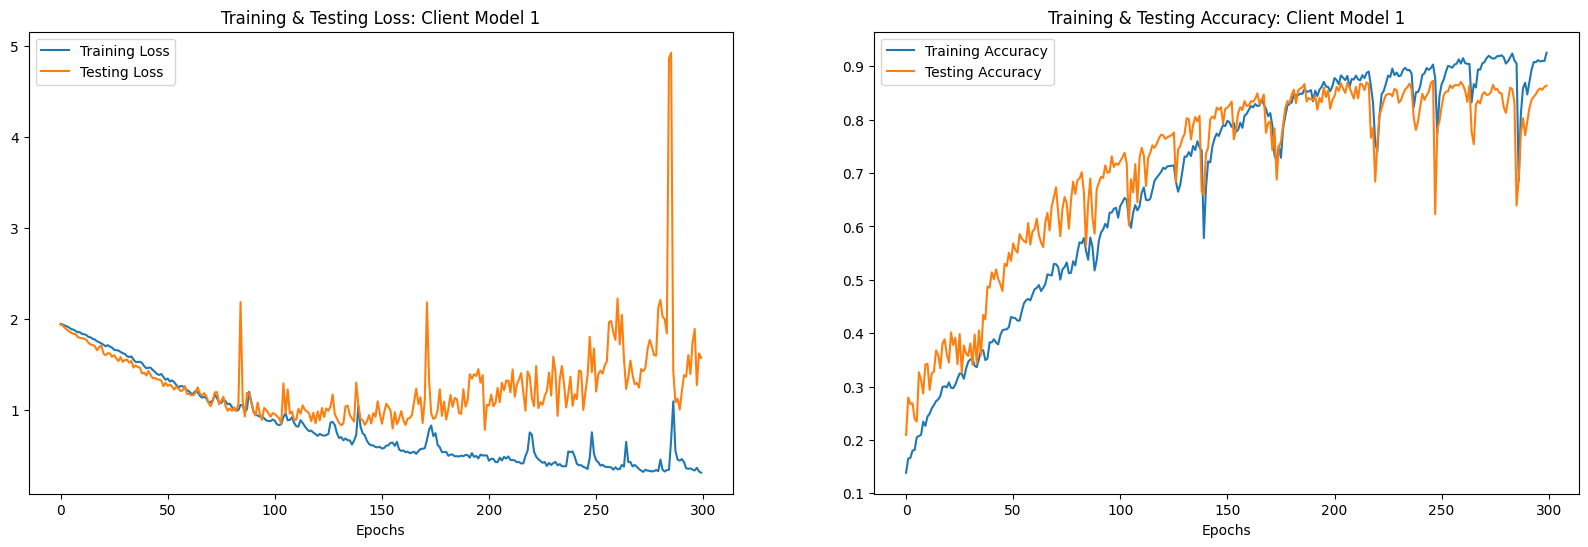

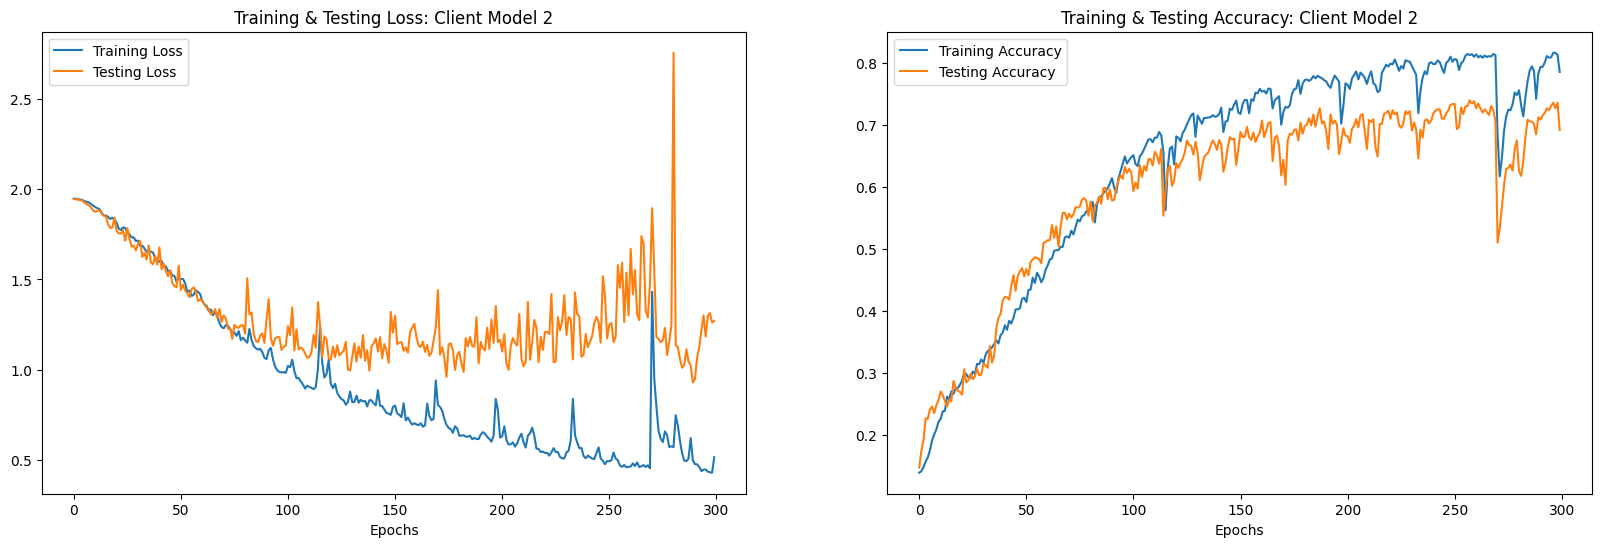

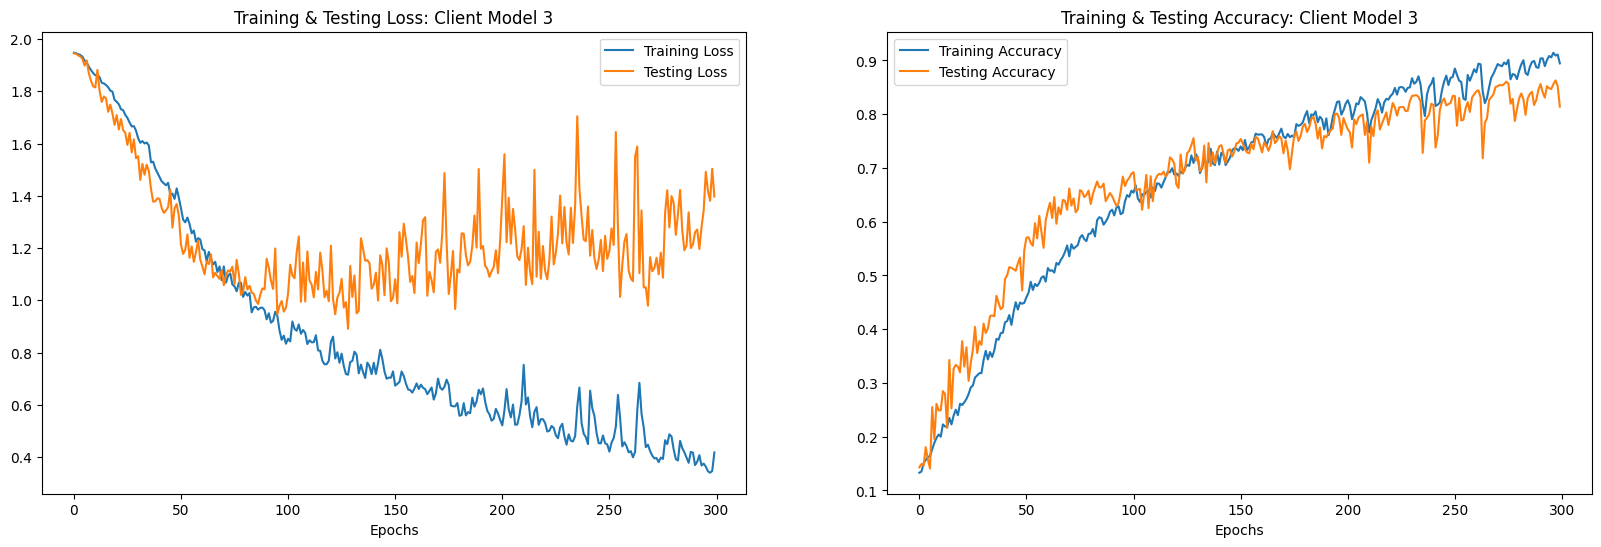

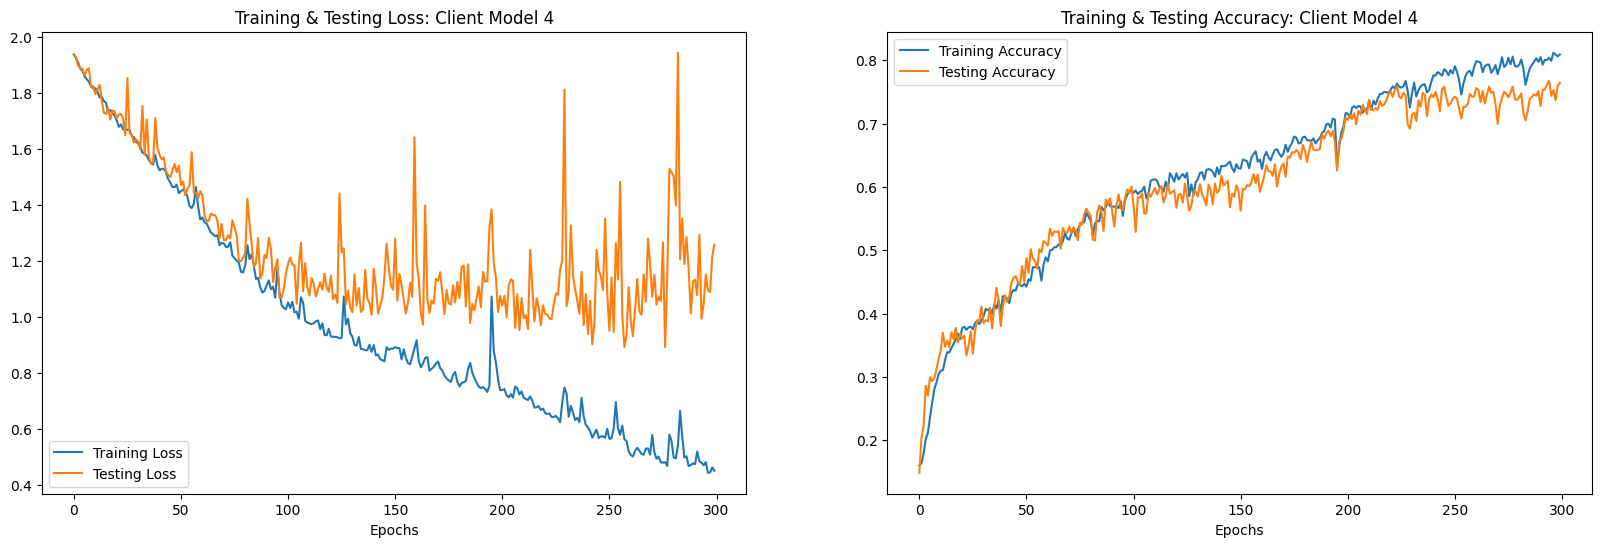

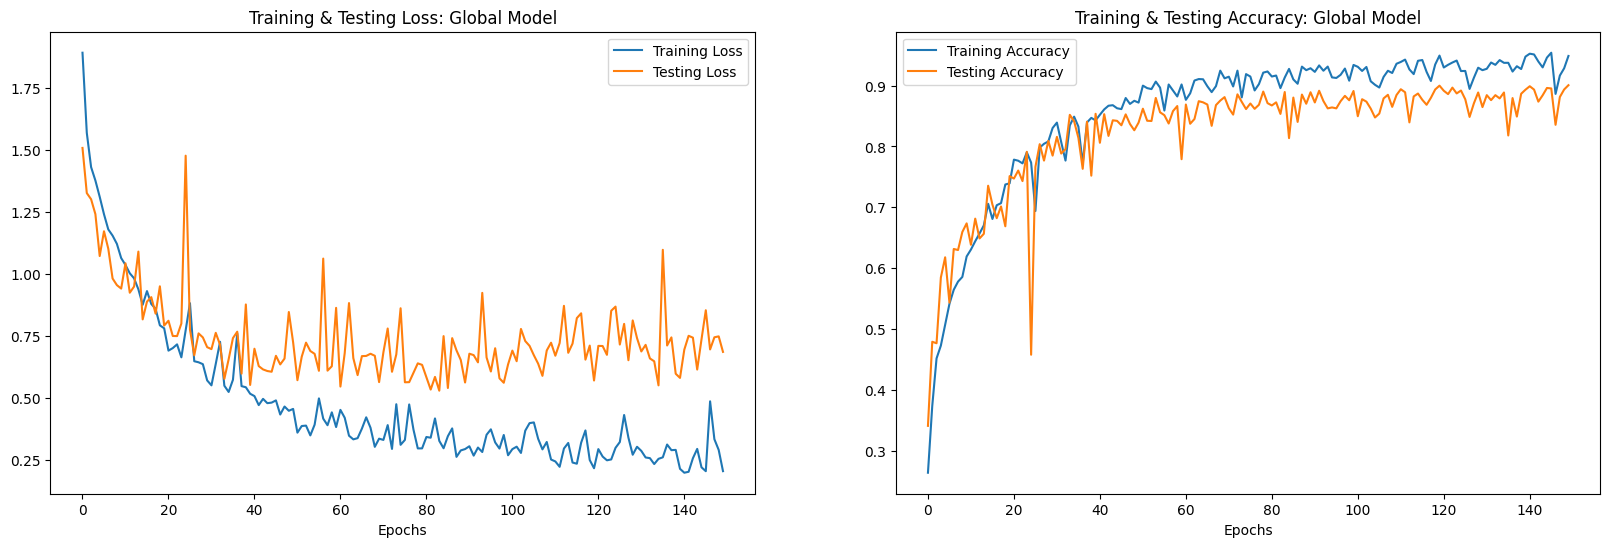

In [38]:
training_plot(history=history1, epoch=300, plot_name="Client Model 1")
training_plot(history=history2, epoch=300, plot_name="Client Model 2")
training_plot(history=history3, epoch=300, plot_name="Client Model 3")
training_plot(history=history4, epoch=300, plot_name="Client Model 4")
training_plot(history=history, epoch=150, plot_name="Global Model")

In [39]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

165/165 [==============================] - 2s 6ms/step


,Predicted Labels,Actual Labels
0,DISGUST,DISGUST
1,ANGRY,ANGRY
2,NEUTRAL,NEUTRAL
3,NEUTRAL,NEUTRAL
4,ANGRY,ANGRY
...,...,...
95,HAPPY,HAPPY
96,ANGRY,ANGRY
97,SURPRISE,DISGUST
98,HAPPY,HAPPY


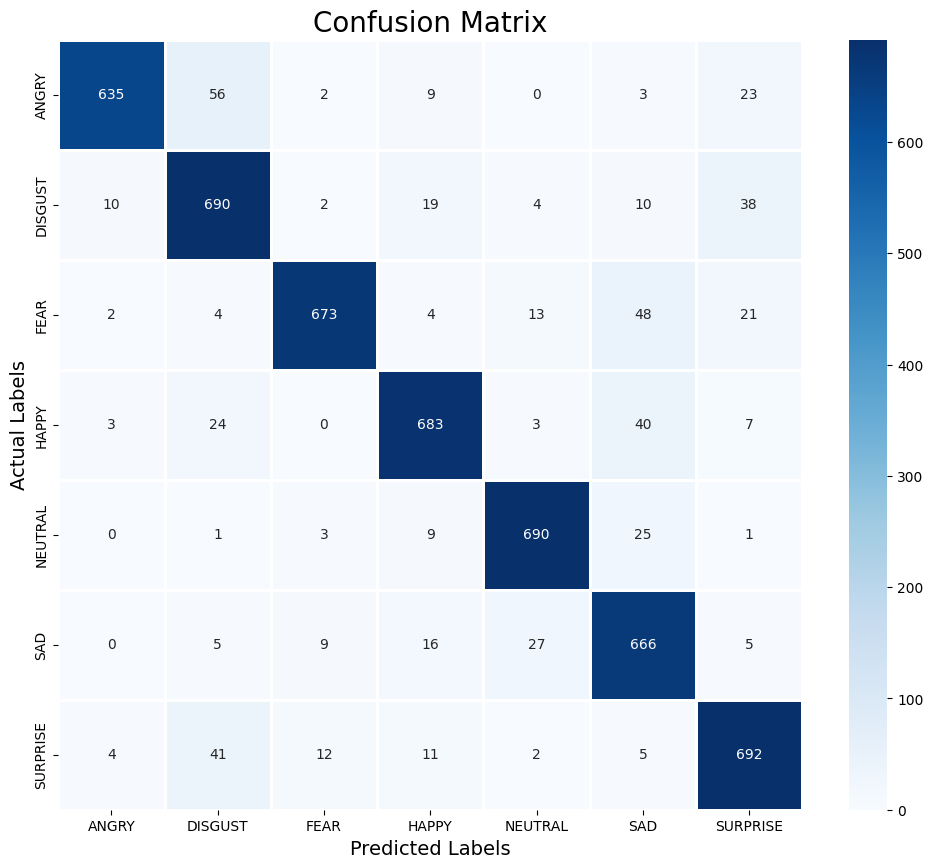

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [41]:
# model_name = 'SUBESCCO_Sequential.h5'
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# # Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

In [42]:
# import json
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

In [43]:
# from keras.models import model_from_json
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("/kaggle/working/saved_models/SUBESCCO_Sequential.h5")
# print("Loaded model from disk")

# Test Custom Audio

In [44]:
# data, sampling_rate = librosa.load('/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO/F_01_OISHI_S_10_ANGRY_4.wav')

In [45]:
# sample = "/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO/F_01_OISHI_S_10_ANGRY_4.wav"
# feature = get_feat(sample, sampling_rate)
# test =np.expand_dims(feature, axis=2)
# livepreds = model.predict(test)
# livepredictions = (encoder.inverse_transform((livepreds)))
# livepredictions